In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import scipy.sparse as sp
from scipy.sparse import load_npz, save_npz
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from netgan import netgan
import sys
sys.path.insert(0, '../src/')
import utils

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hheidrich/miniconda3/envs/ne

#### Load the data

In [2]:
_A_obs = load_npz('../data/datasets/citeseer.npz')
_N = _A_obs.shape[0]

In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
def save_netgan_logs(log_dict, path, num_edges):
    
    overlaps = {i+1:overlap for i, overlap in enumerate(np.array(log_dict['edge_overlaps'])/num_edges)}
    timings = {i+1: timing for i, timing in enumerate(log_dict['times'])}
    
    val_perfs = np.array(log_dict['val_performances'])
    roc_aucs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,0])}
    avg_precs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,1])}
    
    dcts = {'overlap': overlaps,
            'timing': timings,
            'ROC-AUC': roc_aucs,
            'avg_prec': avg_precs,}
    
    str_len = len(str(len(log_dict['generated_graphs'])))
    Path(path).mkdir(parents=True, exist_ok=True)
    for name, dct in dcts.items():
        utils.save_dict(dct, os.path.join(path, f'{name}.pickle'))
    for i, graph in enumerate(log_dict['generated_graphs']):
        save_npz(matrix=sp.csr_matrix(graph), file=os.path.join(path, f'graph_{i+1:0{str_len}d}'))

In [7]:
def run_multiple_netgan_experiments(num_experiments,
                                    log_path,
                                    train_graph,
                                    val_ones,
                                    val_zeros,
                                    max_iters=200000,
                                    eval_every=2000,
                                    plot_every=2000,
                                    rw_len=16,
                                    batch_size=128):
    str_len = len(str(num_experiments-1))
    walker = netgan.utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
    for i in range(num_experiments):
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=val_ones, val_zeros=val_zeros, stopping=1.0,
                               eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        # save logs
        save_netgan_logs(log_dict=log_dict,
                         path=os.path.join(log_path, f'Experiment_{i:0{str_len}d}/sampled_graphs/'),
                         num_edges=train_graph.sum())
        
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_23.ckpt ****
**** Initializing... ****
**** Done.           ****



**** Starting training. ****


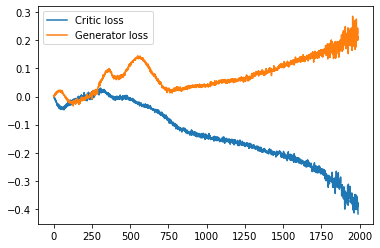

**** Iter 2000   Val ROC 0.774, AP: 0.796, EO 0.006 ****
2500   /200000   training iterations, took 265 seconds so far...


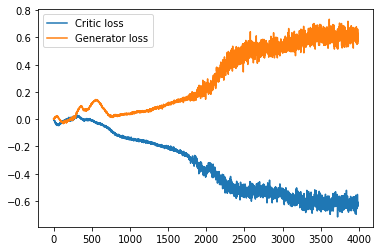

**** Iter 4000   Val ROC 0.854, AP: 0.869, EO 0.014 ****
5000   /200000   training iterations, took 526 seconds so far...


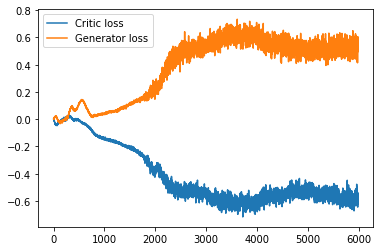

**** Iter 6000   Val ROC 0.879, AP: 0.893, EO 0.032 ****
7500   /200000   training iterations, took 787 seconds so far...


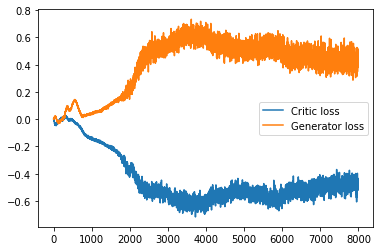

**** Iter 8000   Val ROC 0.918, AP: 0.931, EO 0.043 ****


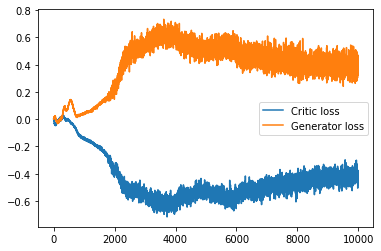

10000  /200000   training iterations, took 1048 seconds so far...
**** Iter 10000  Val ROC 0.940, AP: 0.949, EO 0.083 ****


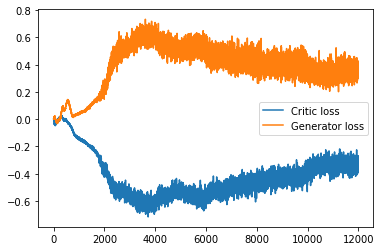

**** Iter 12000  Val ROC 0.952, AP: 0.958, EO 0.140 ****
12500  /200000   training iterations, took 1335 seconds so far...


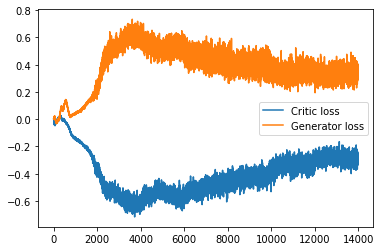

**** Iter 14000  Val ROC 0.956, AP: 0.962, EO 0.193 ****
15000  /200000   training iterations, took 1596 seconds so far...


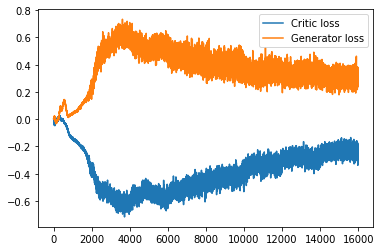

**** Iter 16000  Val ROC 0.950, AP: 0.956, EO 0.242 ****
17500  /200000   training iterations, took 1857 seconds so far...


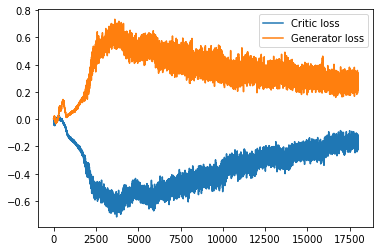

**** Iter 18000  Val ROC 0.953, AP: 0.957, EO 0.290 ****


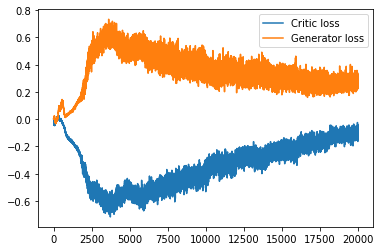

20000  /200000   training iterations, took 2116 seconds so far...
**** Iter 20000  Val ROC 0.942, AP: 0.947, EO 0.354 ****


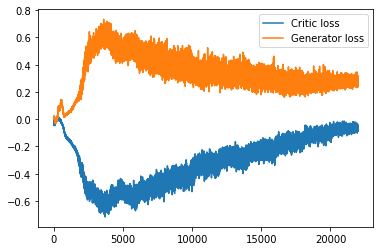

**** Iter 22000  Val ROC 0.949, AP: 0.952, EO 0.378 ****
22500  /200000   training iterations, took 2403 seconds so far...


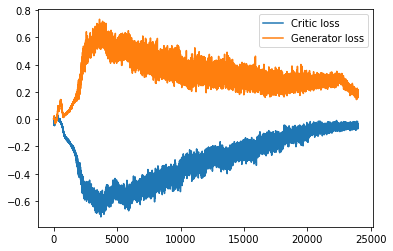

**** Iter 24000  Val ROC 0.946, AP: 0.949, EO 0.400 ****
25000  /200000   training iterations, took 2663 seconds so far...


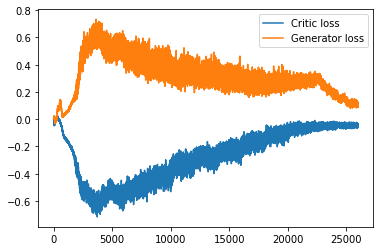

**** Iter 26000  Val ROC 0.944, AP: 0.948, EO 0.467 ****
27500  /200000   training iterations, took 2924 seconds so far...


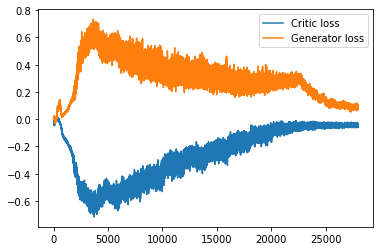

**** Iter 28000  Val ROC 0.941, AP: 0.943, EO 0.531 ****


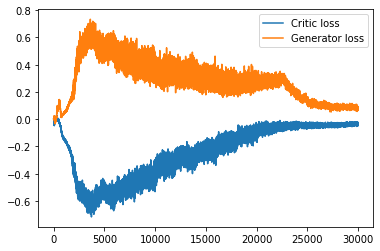

30000  /200000   training iterations, took 3184 seconds so far...
**** Iter 30000  Val ROC 0.938, AP: 0.939, EO 0.626 ****


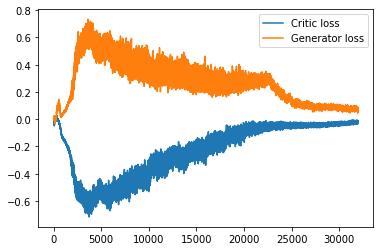

**** Iter 32000  Val ROC 0.930, AP: 0.929, EO 0.701 ****
32500  /200000   training iterations, took 3470 seconds so far...


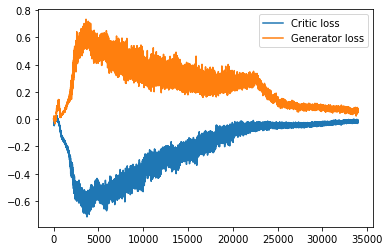

**** Iter 34000  Val ROC 0.924, AP: 0.925, EO 0.746 ****
35000  /200000   training iterations, took 3729 seconds so far...


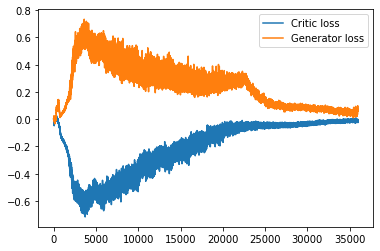

**** Iter 36000  Val ROC 0.918, AP: 0.918, EO 0.776 ****
37500  /200000   training iterations, took 3988 seconds so far...


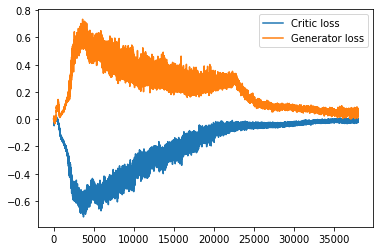

**** Iter 38000  Val ROC 0.921, AP: 0.922, EO 0.804 ****


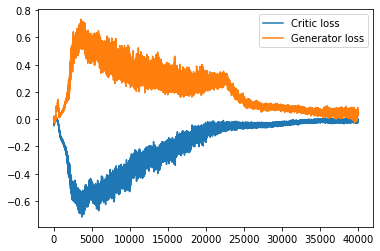

40000  /200000   training iterations, took 4249 seconds so far...
**** Iter 40000  Val ROC 0.912, AP: 0.914, EO 0.817 ****


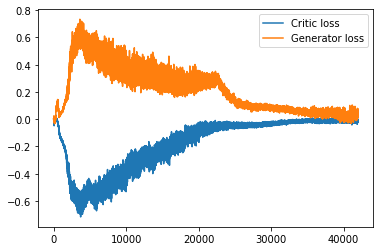

**** Iter 42000  Val ROC 0.907, AP: 0.909, EO 0.813 ****
42500  /200000   training iterations, took 4535 seconds so far...


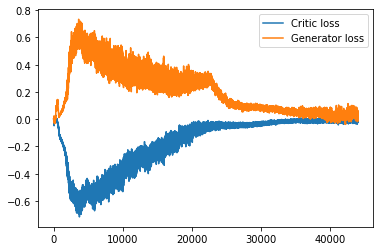

**** Iter 44000  Val ROC 0.913, AP: 0.913, EO 0.822 ****
45000  /200000   training iterations, took 4796 seconds so far...


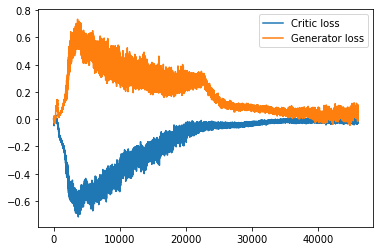

**** Iter 46000  Val ROC 0.906, AP: 0.908, EO 0.815 ****
47500  /200000   training iterations, took 5056 seconds so far...


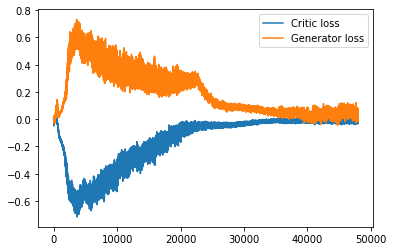

**** Iter 48000  Val ROC 0.900, AP: 0.901, EO 0.816 ****


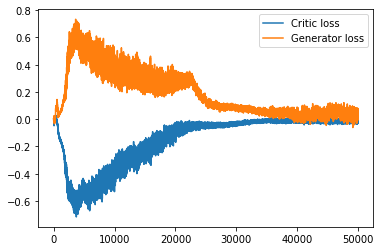

50000  /200000   training iterations, took 5316 seconds so far...
**** Iter 50000  Val ROC 0.911, AP: 0.910, EO 0.822 ****


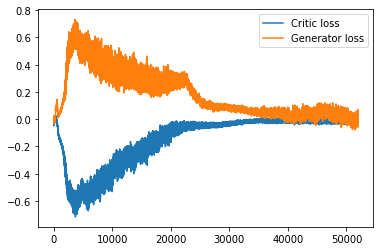

**** Iter 52000  Val ROC 0.912, AP: 0.913, EO 0.816 ****
52500  /200000   training iterations, took 5602 seconds so far...


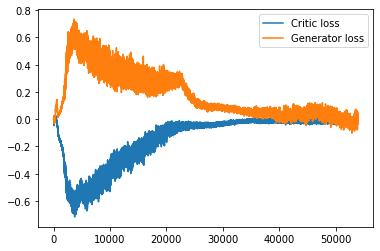

**** Iter 54000  Val ROC 0.910, AP: 0.911, EO 0.831 ****
55000  /200000   training iterations, took 5862 seconds so far...


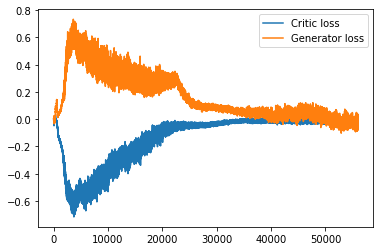

**** Iter 56000  Val ROC 0.913, AP: 0.913, EO 0.817 ****
57500  /200000   training iterations, took 6123 seconds so far...


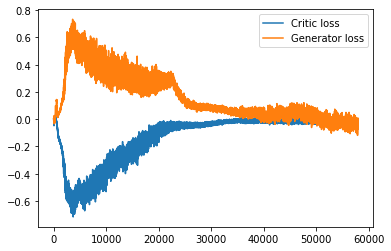

**** Iter 58000  Val ROC 0.911, AP: 0.913, EO 0.817 ****


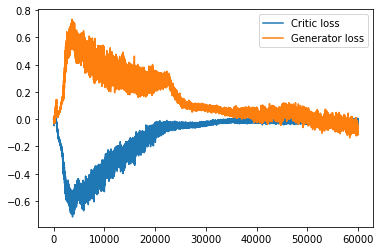

60000  /200000   training iterations, took 6383 seconds so far...
**** Iter 60000  Val ROC 0.906, AP: 0.907, EO 0.818 ****


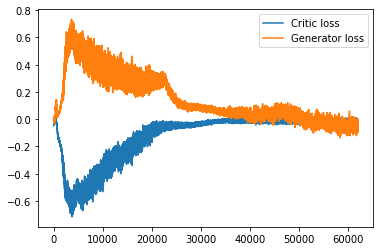

**** Iter 62000  Val ROC 0.906, AP: 0.907, EO 0.819 ****
62500  /200000   training iterations, took 6670 seconds so far...


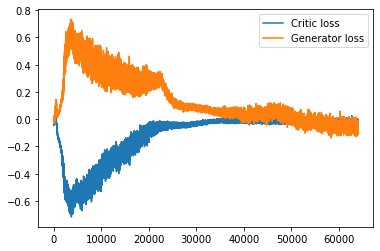

**** Iter 64000  Val ROC 0.907, AP: 0.909, EO 0.822 ****
65000  /200000   training iterations, took 6930 seconds so far...


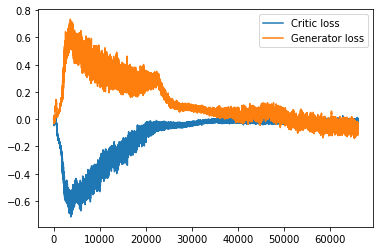

**** Iter 66000  Val ROC 0.908, AP: 0.910, EO 0.821 ****
67500  /200000   training iterations, took 7190 seconds so far...


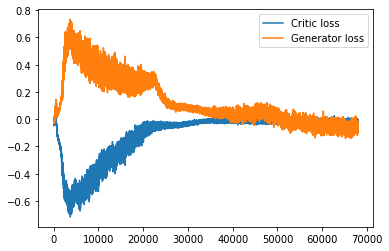

**** Iter 68000  Val ROC 0.910, AP: 0.912, EO 0.819 ****


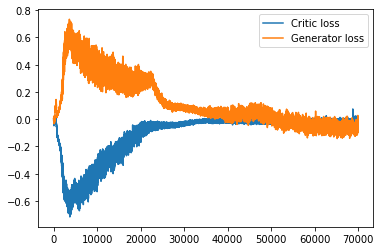

70000  /200000   training iterations, took 7450 seconds so far...
**** Iter 70000  Val ROC 0.909, AP: 0.911, EO 0.817 ****


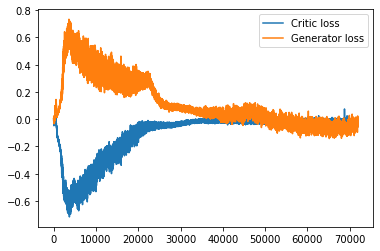

**** Iter 72000  Val ROC 0.915, AP: 0.915, EO 0.820 ****
72500  /200000   training iterations, took 7736 seconds so far...


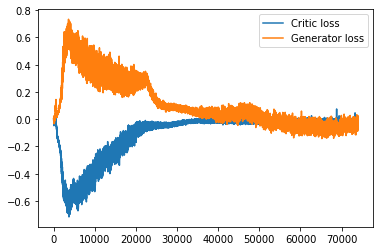

**** Iter 74000  Val ROC 0.905, AP: 0.908, EO 0.812 ****
75000  /200000   training iterations, took 7996 seconds so far...


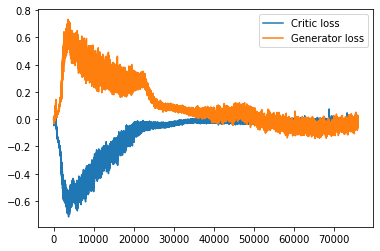

**** Iter 76000  Val ROC 0.908, AP: 0.910, EO 0.811 ****
77500  /200000   training iterations, took 8256 seconds so far...


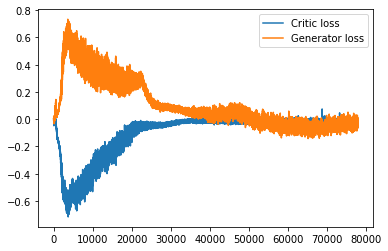

**** Iter 78000  Val ROC 0.910, AP: 0.911, EO 0.812 ****


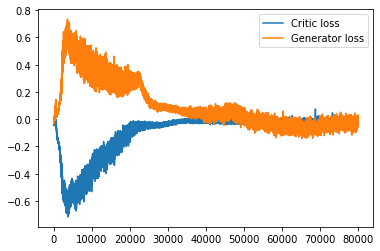

80000  /200000   training iterations, took 8517 seconds so far...
**** Iter 80000  Val ROC 0.908, AP: 0.909, EO 0.816 ****


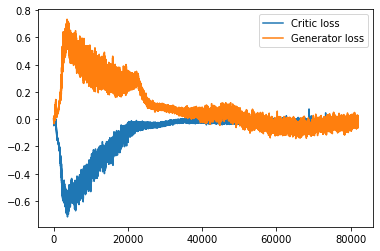

**** Iter 82000  Val ROC 0.902, AP: 0.905, EO 0.820 ****
82500  /200000   training iterations, took 8803 seconds so far...


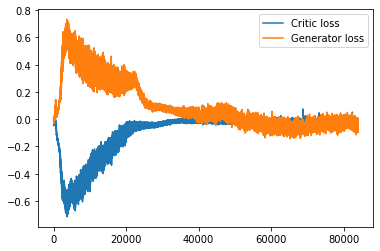

**** Iter 84000  Val ROC 0.905, AP: 0.903, EO 0.806 ****
85000  /200000   training iterations, took 9064 seconds so far...


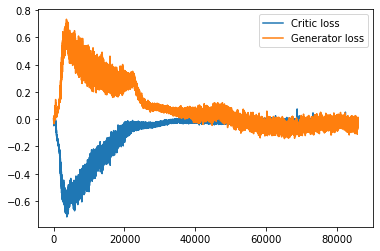

**** Iter 86000  Val ROC 0.906, AP: 0.908, EO 0.813 ****
87500  /200000   training iterations, took 9323 seconds so far...


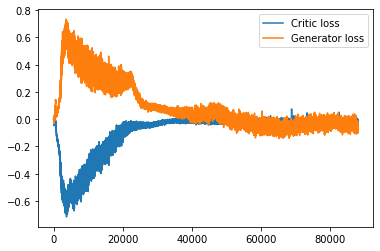

**** Iter 88000  Val ROC 0.905, AP: 0.907, EO 0.818 ****


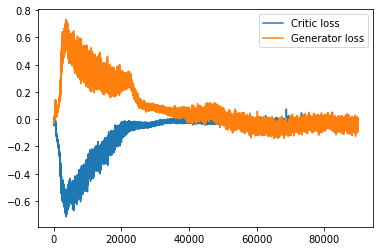

90000  /200000   training iterations, took 9583 seconds so far...
**** Iter 90000  Val ROC 0.905, AP: 0.904, EO 0.807 ****


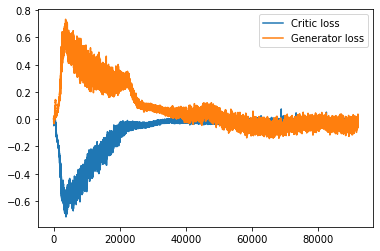

**** Iter 92000  Val ROC 0.908, AP: 0.907, EO 0.821 ****
92500  /200000   training iterations, took 9870 seconds so far...


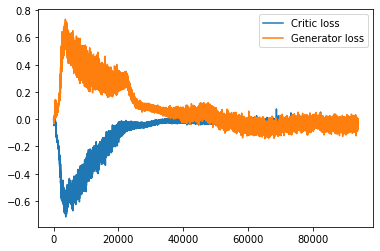

**** Iter 94000  Val ROC 0.904, AP: 0.903, EO 0.815 ****
95000  /200000   training iterations, took 10130 seconds so far...


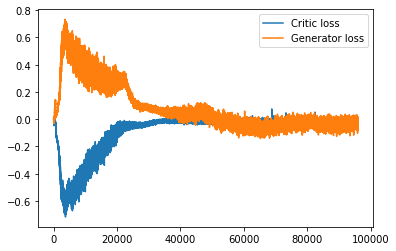

**** Iter 96000  Val ROC 0.905, AP: 0.907, EO 0.818 ****
97500  /200000   training iterations, took 10390 seconds so far...


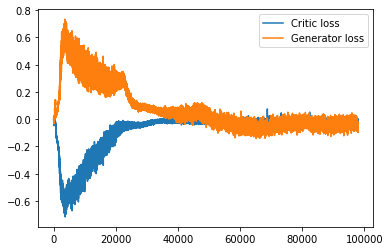

**** Iter 98000  Val ROC 0.903, AP: 0.903, EO 0.817 ****


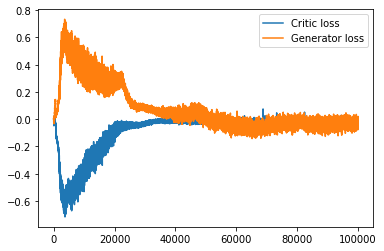

100000 /200000   training iterations, took 10651 seconds so far...
**** Iter 100000 Val ROC 0.905, AP: 0.903, EO 0.808 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


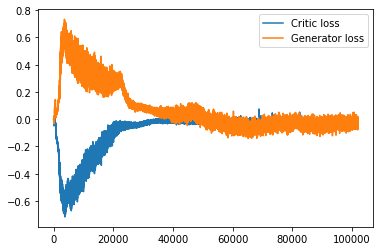

**** Iter 102000 Val ROC 0.911, AP: 0.908, EO 0.814 ****
102500 /200000   training iterations, took 10937 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


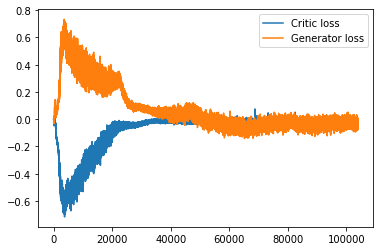

**** Iter 104000 Val ROC 0.902, AP: 0.900, EO 0.816 ****
105000 /200000   training iterations, took 11198 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


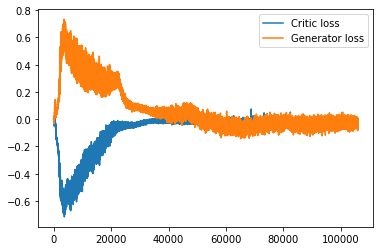

**** Iter 106000 Val ROC 0.904, AP: 0.902, EO 0.812 ****
107500 /200000   training iterations, took 11459 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


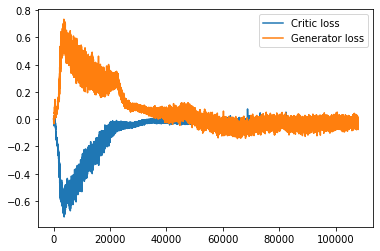

**** Iter 108000 Val ROC 0.904, AP: 0.903, EO 0.815 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


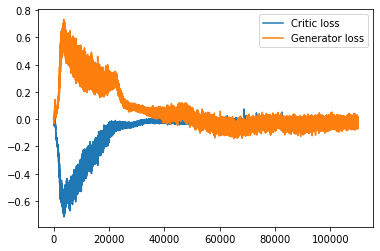

110000 /200000   training iterations, took 11720 seconds so far...
**** Iter 110000 Val ROC 0.901, AP: 0.899, EO 0.817 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


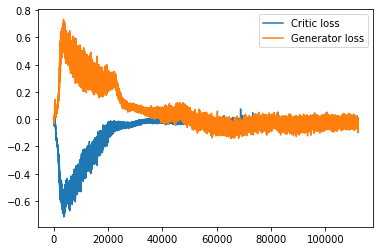

**** Iter 112000 Val ROC 0.903, AP: 0.904, EO 0.808 ****
112500 /200000   training iterations, took 12007 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


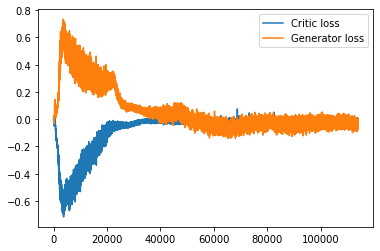

**** Iter 114000 Val ROC 0.905, AP: 0.906, EO 0.821 ****
115000 /200000   training iterations, took 12267 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


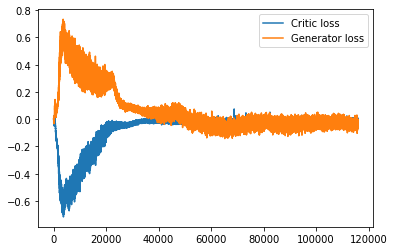

**** Iter 116000 Val ROC 0.901, AP: 0.902, EO 0.821 ****
117500 /200000   training iterations, took 12528 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


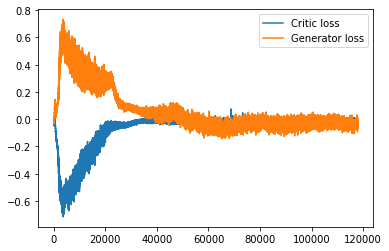

**** Iter 118000 Val ROC 0.898, AP: 0.901, EO 0.816 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


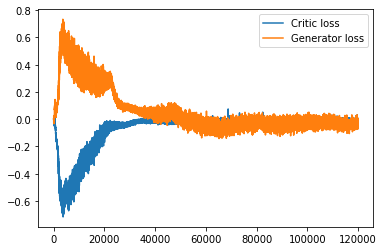

120000 /200000   training iterations, took 12789 seconds so far...
**** Iter 120000 Val ROC 0.901, AP: 0.903, EO 0.831 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


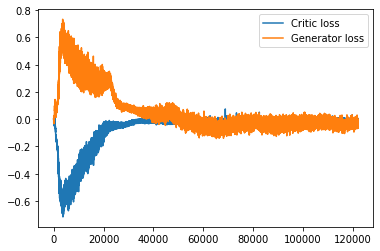

**** Iter 122000 Val ROC 0.904, AP: 0.904, EO 0.817 ****
122500 /200000   training iterations, took 13076 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


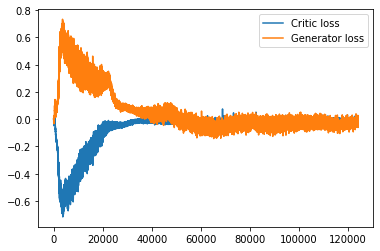

**** Iter 124000 Val ROC 0.893, AP: 0.895, EO 0.817 ****
125000 /200000   training iterations, took 13337 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


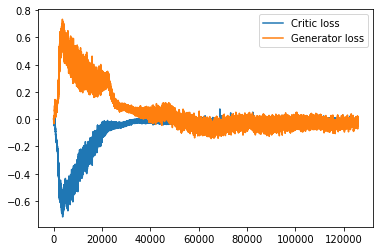

**** Iter 126000 Val ROC 0.903, AP: 0.904, EO 0.821 ****
127500 /200000   training iterations, took 13597 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


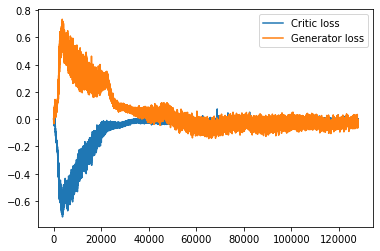

**** Iter 128000 Val ROC 0.900, AP: 0.903, EO 0.809 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


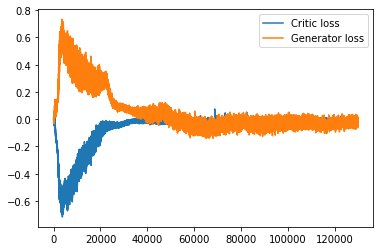

130000 /200000   training iterations, took 13858 seconds so far...
**** Iter 130000 Val ROC 0.896, AP: 0.899, EO 0.804 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


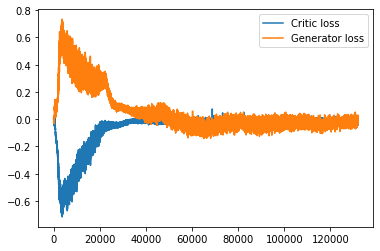

**** Iter 132000 Val ROC 0.899, AP: 0.902, EO 0.816 ****
132500 /200000   training iterations, took 14144 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


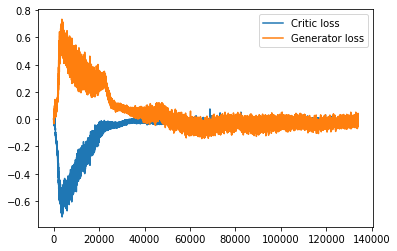

**** Iter 134000 Val ROC 0.905, AP: 0.905, EO 0.815 ****
135000 /200000   training iterations, took 14405 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


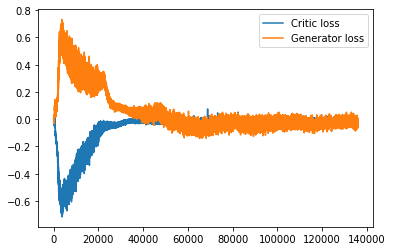

**** Iter 136000 Val ROC 0.902, AP: 0.902, EO 0.817 ****
137500 /200000   training iterations, took 14665 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


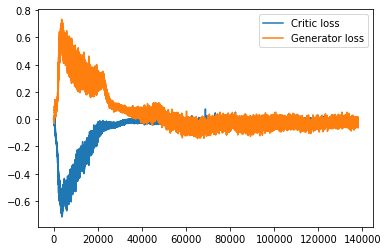

**** Iter 138000 Val ROC 0.900, AP: 0.902, EO 0.819 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


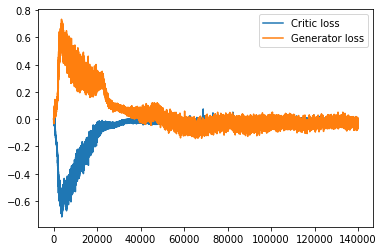

140000 /200000   training iterations, took 14926 seconds so far...
**** Iter 140000 Val ROC 0.900, AP: 0.900, EO 0.818 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


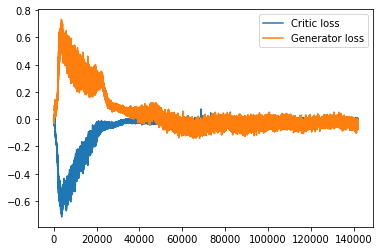

**** Iter 142000 Val ROC 0.902, AP: 0.903, EO 0.815 ****
142500 /200000   training iterations, took 15213 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


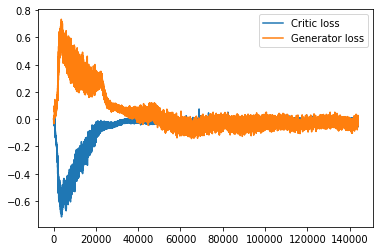

**** Iter 144000 Val ROC 0.901, AP: 0.900, EO 0.812 ****
145000 /200000   training iterations, took 15474 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


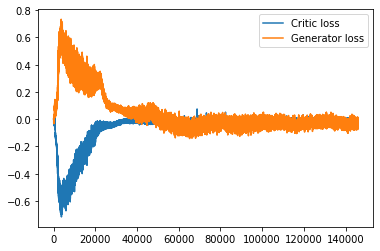

**** Iter 146000 Val ROC 0.904, AP: 0.903, EO 0.813 ****
147500 /200000   training iterations, took 15734 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


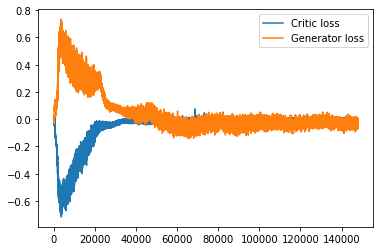

**** Iter 148000 Val ROC 0.905, AP: 0.904, EO 0.822 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


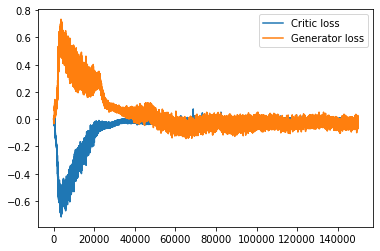

150000 /200000   training iterations, took 15995 seconds so far...
**** Iter 150000 Val ROC 0.901, AP: 0.901, EO 0.819 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


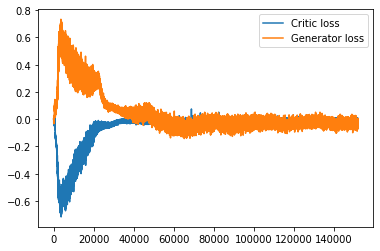

**** Iter 152000 Val ROC 0.899, AP: 0.900, EO 0.808 ****
152500 /200000   training iterations, took 16282 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


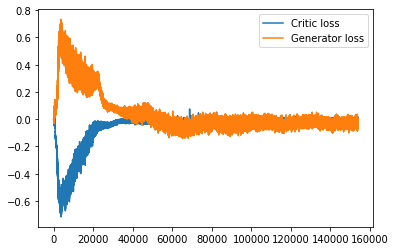

**** Iter 154000 Val ROC 0.908, AP: 0.906, EO 0.817 ****
155000 /200000   training iterations, took 16542 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


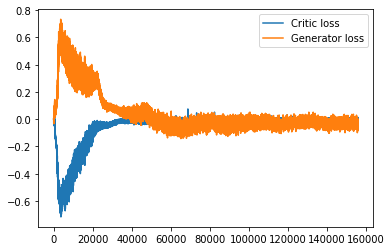

**** Iter 156000 Val ROC 0.902, AP: 0.901, EO 0.803 ****
157500 /200000   training iterations, took 16804 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


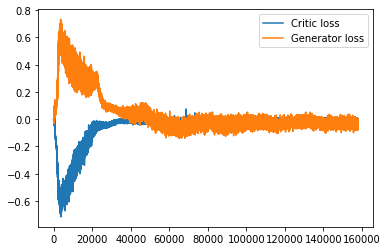

**** Iter 158000 Val ROC 0.907, AP: 0.906, EO 0.807 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


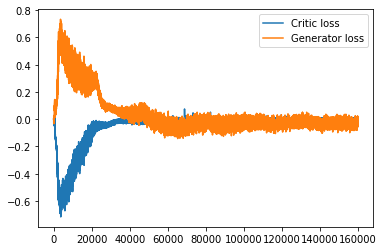

160000 /200000   training iterations, took 17064 seconds so far...
**** Iter 160000 Val ROC 0.911, AP: 0.913, EO 0.802 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


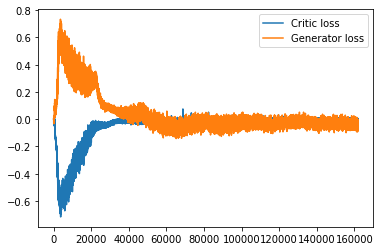

**** Iter 162000 Val ROC 0.894, AP: 0.894, EO 0.820 ****
162500 /200000   training iterations, took 17351 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


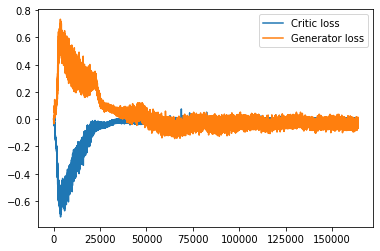

**** Iter 164000 Val ROC 0.898, AP: 0.900, EO 0.814 ****
165000 /200000   training iterations, took 17611 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


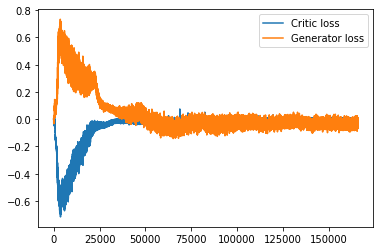

**** Iter 166000 Val ROC 0.903, AP: 0.904, EO 0.815 ****
167500 /200000   training iterations, took 17872 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


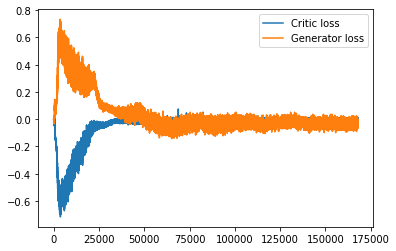

**** Iter 168000 Val ROC 0.893, AP: 0.896, EO 0.813 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


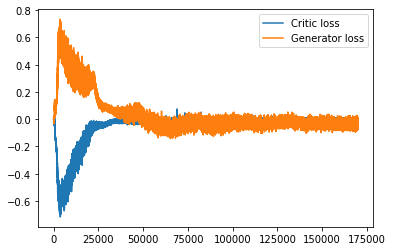

170000 /200000   training iterations, took 18133 seconds so far...
**** Iter 170000 Val ROC 0.896, AP: 0.898, EO 0.811 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


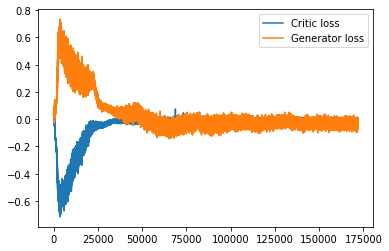

**** Iter 172000 Val ROC 0.901, AP: 0.902, EO 0.803 ****
172500 /200000   training iterations, took 18420 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


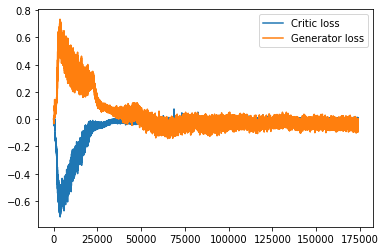

**** Iter 174000 Val ROC 0.902, AP: 0.901, EO 0.803 ****
175000 /200000   training iterations, took 18680 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


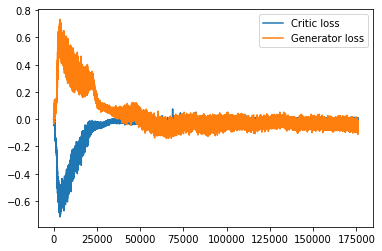

**** Iter 176000 Val ROC 0.899, AP: 0.900, EO 0.811 ****
177500 /200000   training iterations, took 18941 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


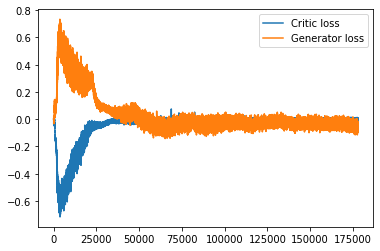

**** Iter 178000 Val ROC 0.901, AP: 0.902, EO 0.808 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


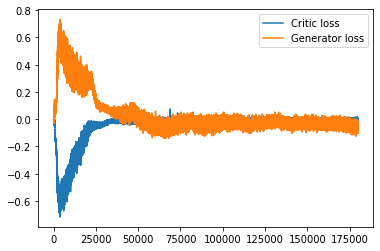

180000 /200000   training iterations, took 19203 seconds so far...
**** Iter 180000 Val ROC 0.899, AP: 0.902, EO 0.819 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


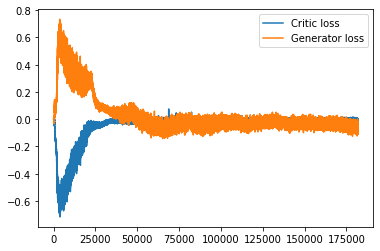

**** Iter 182000 Val ROC 0.897, AP: 0.898, EO 0.808 ****
182500 /200000   training iterations, took 19489 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


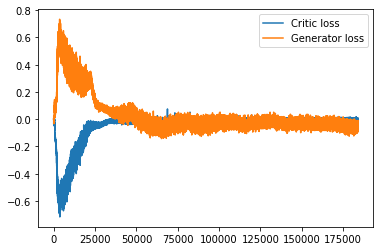

**** Iter 184000 Val ROC 0.894, AP: 0.895, EO 0.816 ****
185000 /200000   training iterations, took 19749 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


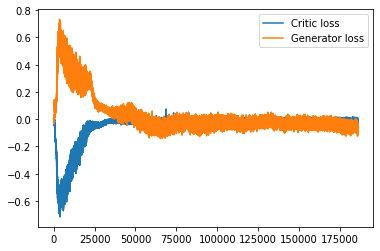

**** Iter 186000 Val ROC 0.900, AP: 0.902, EO 0.816 ****
187500 /200000   training iterations, took 20010 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


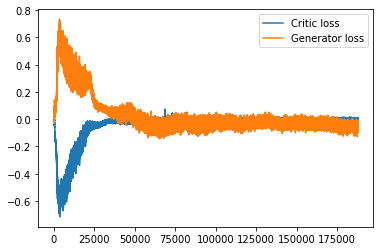

**** Iter 188000 Val ROC 0.896, AP: 0.898, EO 0.799 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


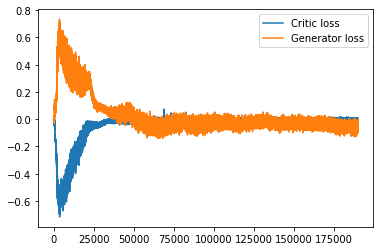

190000 /200000   training iterations, took 20270 seconds so far...
**** Iter 190000 Val ROC 0.901, AP: 0.902, EO 0.820 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


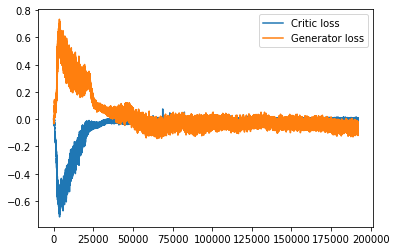

**** Iter 192000 Val ROC 0.898, AP: 0.899, EO 0.811 ****


In [ ]:
run_multiple_netgan_experiments(num_experiments=5,
                                log_path='../logs/citeseer/baseline_NetGan/',
                                train_graph=train_graph,
                                val_ones=val_ones,
                                val_zeros=val_zeros,
                                max_iters=200000)

In [9]:
#